In [4]:
from envs.cartpole_pret2 import Cartpole
from filters.NN_filters import FCN
import numpy as np
import matplotlib.pyplot as plt
import torch 
from tqdm import tqdm

env = Cartpole(0, 0, focus=0)
# initialize cartpole
steps_trajectory = 10
delta_t_steps = 200
epochs = 100000
states_whole_set = []
actions_whole_set = []
label_whole_set = []
for i in tqdm(range(epochs), desc="Training Epochs"):
    states,actions, done = env.sample_data_real_trajectory(steps_trajectory)
    states_whole_set.append(states[:-1])
    actions_whole_set.append(actions)
    labels = np.ones_like(actions)
    if done:
        labels[-delta_t_steps:] = -1
    else:
        pass # Whole Trajectory is safe
    label_whole_set.append(labels)
states_whole_set = np.concatenate(states_whole_set)
actions_whole_set = np.concatenate(actions_whole_set)
label_whole_set = np.concatenate(label_whole_set)
actions_whole_set= actions_whole_set.reshape(-1,1,1)
label_whole_set = label_whole_set.reshape(-1,1)
np.savez("exps/cartpole/training_dataTrajectories.npz", train_states = states_whole_set, train_inputs = actions_whole_set, train_labels = label_whole_set)

Training Epochs: 100%|██████████| 100000/100000 [00:57<00:00, 1742.29it/s]


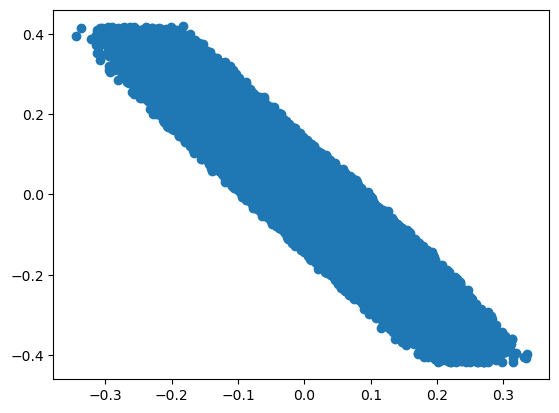

float64


In [21]:
training_data = np.load("exps/cartpole/training_dataTrajectories.npz")
train_states = training_data["train_states"]
train_inputs = training_data["train_inputs"].astype(np.float64)
train_labels = training_data["train_labels"]
train_size = int(train_states.shape[0]*0.9)
val_states = train_states[train_size:,:]
train_states = train_states[:train_size,:]
val_inputs = train_inputs[train_size:,:,:]
train_inputs = train_inputs[:train_size,:,:]
val_labels = train_labels[train_size:,:]
train_labels = train_labels[:train_size,:]
plt.scatter(train_states[:, 0], train_states[:, 2])
plt.show()
print(train_inputs.dtype)

In [ ]:

# initialize network
input_size = 4
output_size = 2
n_layers = 5
size=1000
activation = 'relu'
lr = 5e-4
sc = 1
gamma_pos = 1
gamma_neg = 5
model = FCN(input_size, output_size, n_layers, size, activation, lr, sc, gamma_pos, gamma_neg)
model.FCN.train()

# train network
epochs = 200
num_log = 4

train_losses = []
val_losses = []
best_loss = float('inf')
print("Training model...")
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    for i in range(5):
        train_loss = model.update2(train_states, train_inputs, train_labels, env)
    model.scheduler.step()
    if epoch % 1 == 0:
        train_losses.append(train_loss)
        val_loss = model.get_val_loss(val_states, val_inputs, val_labels, env)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            torch.save({
            'model_state_dict': model.FCN.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            }, 'exps/cartpole/model.pth')
        train_losses = train_losses[-500:]
        val_losses = val_losses[-500:]
        print("epoch:", epoch, 'train loss:', train_loss)
        print("epoch:", epoch, 'val loss:', val_loss)

model.FCN.eval()

Training model...


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
#Cartpole Vec not working theta calc must be wrong
from envs.cartpole_pret_Vector import CartpoleVec
import time
env = CartpoleVec(disc_steps=20, vector_size=5)
o = env.reset()
#a =  env.np_random.uniform(low=-0.05, high=0.05, size=(5,1))
for i in range(100):
    a = env.action_space.sample()/100
    env.step(a)
    env.render()
    time.sleep(0.2)


/home/artur/miniconda3/envs/fsrl/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
